# Heart detection project

1. Определение методов и метрик
2. Сбор данных.
3. Подготовка данных.
4. Выбор и обучение модели.
5. Тестирование модели.
6. Подготовка модели к запуску в работу

## 0. Постановка задачи
Необходимо создать модель, которая будет обнаруживать жест "сердечко" в реальном времени на CPU.
mAP: выше 50%


## 1. Определение методов и метрик

Для задачи обнаружения объектов можно использовать целый набор алгоритмов в зависимости от сложности объекта.
1. Каскады Haar и HOG. (работает быстро на CPU, но низка обобщающая способность) Viola-Jones method (2001)
2. Нейросети (YOLO, Faster-RCNN, SSD)

### 1. Faster-RCNN

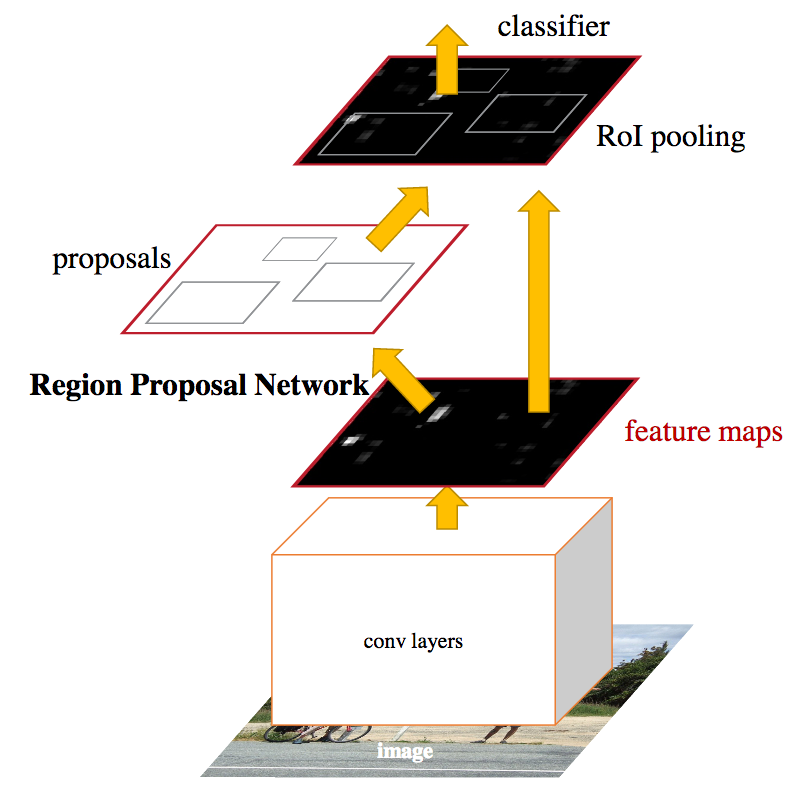
Сеть состоит из двух частей. Сначала сеть извлекает признаки из изображения, они отправляются в RPN (Region proposal network) которая предсказывает ограничивающие прямоугольники объектов и вероятность того что в прямоугольнике есть объект. Следующим действие применяется Non-Maximal Suppression. RPN генерирует 9 якорей разного размера в каждой точке признакового описания. NMS с коэффициентом 0,7 помогает оставить только наиболее вероятные. В оригинальной статье применяется ROI_Pooling. Когда размер оставшегося якоря проходится с помощью max pooling. Далее эти регионы классифицируются при помощи полносвязных слоев.

### 2. Single Shot Multibox Detector (SSD)
На первом этапе используется полностью серточнаянейронная сеть, например VGG.
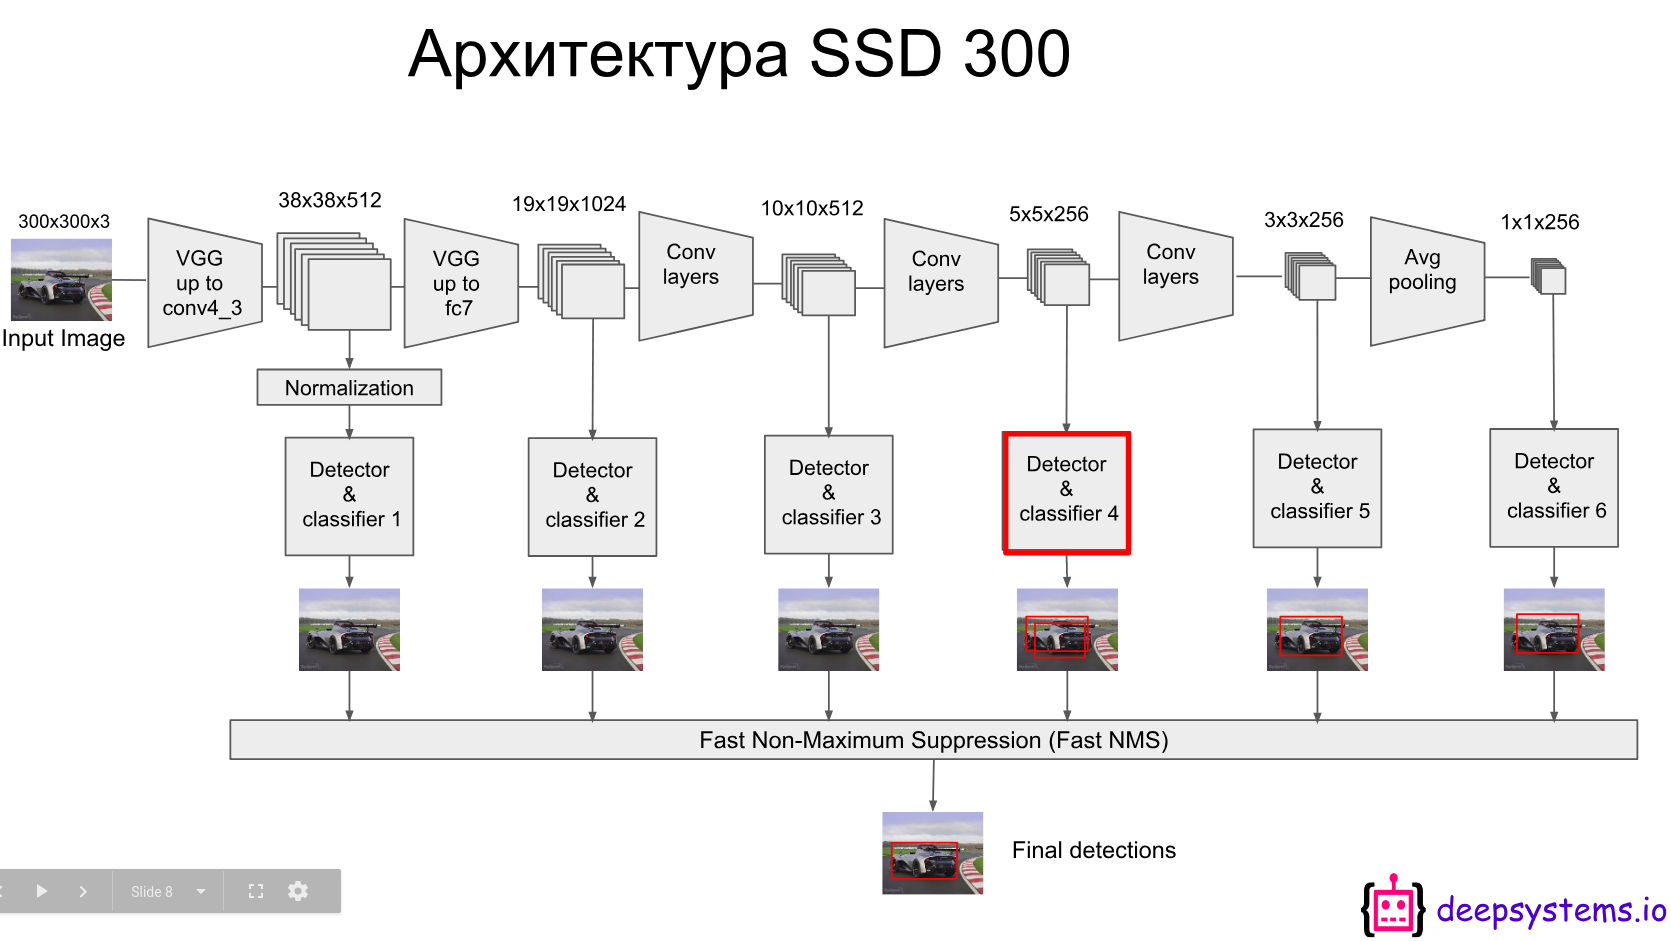
Далее после каждой группы сверток набор признаков отправляется на генерацию боксов, выравнивание боксов и классификацию объектов. Это сделано для обнаружения объектов разных размеров. Генерация боксов в центре каждого фичемапа генерируется N якорей разного размера, для кажого считается коэффициенты коррекции бокса по ширине высоте и коррекция центра, а также классификация на K + 1 классов. Последним шагом все детекции проходят через NMS. И остаются только самые вероятные.


Tensorflow object detection API предлагает широкий выбор неройсетей из семейства Faster-RCNN и SSD

### Метрика
Основная метрика для задачи object detection mAP.
где m - mean, AP- average Precision.
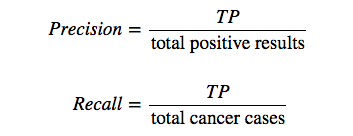


Intersection over union

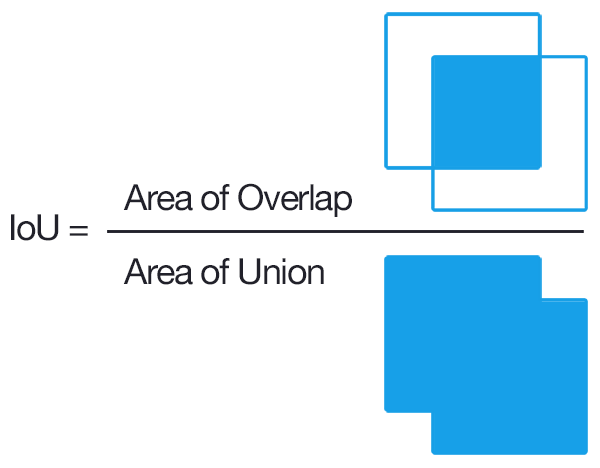


mAP@0.5 считается как площадь под Precision-Recall кривой при IoU 0.5. Среднее между всеми классами.

Более жесткой метрикой является mAP@[.5:.95]

# Сбор данных
Если у вас нет датасета можно использовать Google:
![title](dataset/2.jpg)

Или пройтись по офису с фотоаппаратом:
![title](dataset/IMG_1424.JPG)

# 3. Подготовка данных
Данные нужно разметить для этого есть ряд библиотек и инструментов.
Есть неплохой онлайн сервис https://supervise.ly/ где можно загрузить изображения, разметить и сохранить боксы в удобном формате.
Я часто использую https://github.com/tzutalin/labelImg - удобный иснтрумент, горячие клавиши, все как полагается. Разметка в xml. 


## Применение LabelImg

Для обучения модели в Tensorflow object detection API нужно иметь файл labelmap.pbtxt
```
item {
  id: 1
  name: 'heart'
}
```
Он содержит список всех классов.
Далее выборку необходимо разделить на тренировочную, валидационную и тестовую.

Далее необходимо конвертировать xml в csv

In [1]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET

def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

image_path = os.path.join(os.getcwd(), 'dataset')
xml_df = xml_to_csv(image_path)
xml_df.to_csv('hearts_dataset.csv', index=None)
print('Successfully converted xml to csv.')

Successfully converted xml to csv.


С помощью стандартной функции train_test_split разобьем наши данные на тренировочную, валидационную и тестовую выборки

In [2]:
import sys

sys.path.append('/tensorflow/models/research/slim')
sys.path.append('/tensorflow/models/research')
print(sys.path)

['', '/hearts', '/hearts/models/research', '/hearts/models/research/slim', '/usr/local/lib/python36.zip', '/usr/local/lib/python3.6', '/usr/local/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/site-packages', '/usr/local/lib/python3.6/site-packages/IPython/extensions', '/root/.ipython', '/tensorflow/models/research/slim', '/tensorflow/models/research']


In [6]:
%cd /tensorflow/models/research
!export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim
%cd /ws/ws

/tensorflow/models/research
/ws/ws


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

## Your code here 
heart_ds = pd.read_csv('hearts_dataset.csv')
train, test = train_test_split(heart_ds, test_size=50, random_state=0)
train, val = train_test_split(train, test_size=120)
train.to_csv('hearts_train.csv')
val.to_csv('hearts_val.csv')
test.to_csv('hearts_test.csv')

Когда выборка разделена, необходимо создать .tfrecords файлы

In [7]:
# Convert images and a csv file to a sharded tfrecord

import os
import pandas as pd
import tensorflow as tf

from object_detection.utils import dataset_util

import contextlib2
from object_detection.dataset_tools import tf_record_creation_util


# flags = tf.app.flags
# flags.DEFINE_string('output_path', 'test_dataset.record', 'Path to output TFRecord')
# FLAGS = flags.FLAGS

def create_tf_example(frame_name, examples, image_dir):
    height = examples.iloc[0]['height']  # Image height
    width = examples.iloc[0]['width']  # Image width
    filename = frame_name # Filename of the image. Empty if image is not from file

    full_path = os.path.join(image_dir, filename)
    try:
        with tf.gfile.GFile(full_path, 'rb') as fid:
            encoded_image_data = fid.read()
    except:
        with tf.gfile.GFile(full_path.replace('.jpg','.JPG'), 'rb') as fid:
            encoded_image_data = fid.read()
    image_format = b'jpeg'  # b'jpeg' or b'png'

    xmins = [] # List of normalized left x coordinates in bounding box (1 per box)
    xmaxs = [] # List of normalized right x coordinates in bounding box
             # (1 per box)
    ymins = [] # List of normalized top y coordinates in bounding box (1 per box)
    ymaxs = [] # List of normalized bottom y coordinates in bounding box
             # (1 per box)

    classes_text = []
    classes = []

    for idx, example in examples.iterrows():
        xmins.append(example['xmin']/width)
        xmaxs.append(example['xmax']/width)

        ymins.append(example['ymin']/height)
        ymaxs.append(example['ymax']/height)

        classes_text.append('heart'.encode('utf8')) # These 2 lines are hardcoded, should probably change this
        classes.append(1)
    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename.encode('utf8')),
        'image/source_id': dataset_util.bytes_feature(filename.encode('utf8')),
        'image/encoded': dataset_util.bytes_feature(encoded_image_data),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes)}))
    return tf_example

def write_tfr(annotations_path, output_folder, image_dir = 'dataset'):
    for i in annotations_path:
        examples = pd.read_csv(i)
        # annotations_path = 'hearts_val.csv'
        subset = i.split('.')[0].split('_')[-1]
        num_shards=10
        output_filebase='data/{}_records.record'.format(subset)
        with contextlib2.ExitStack() as tf_record_close_stack:
            output_tfrecords = tf_record_creation_util.open_sharded_output_tfrecords(
                tf_record_close_stack, output_filebase, num_shards)

            for index, frame_name in enumerate(examples.filename.unique()):
                tf_example = create_tf_example(
                    frame_name, examples[examples.filename == frame_name], image_dir)
                output_shard_index = index % num_shards
                output_tfrecords[output_shard_index].write(
                    tf_example.SerializeToString())


In [9]:
write_tfr(['hearts_val.csv', 'hearts_test.csv', 'hearts_train.csv'], 'data', 'dataset')

### Теперь подготовим структуру папок для модели
Документация рекомендует следующую структуру
```
+data
  -label_map file
  -train TFRecord files
  -eval TFRecord files
+models
  +model
    -pipeline config file
    -starting weights
+training
```
директория 'data' должна содержать файлы .tfrecords и labelmap.pbtxt  
'models' содержит папки с разыми моделями  
'training' будет содержать промежуточные данные чекпоинты модели и логи для tensorboard.  

### Настройка пайплайна
Предобученные модели можно скачать по ссылке [here](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md).  
Теперь изменить pipeline.config файл:  

`num_classes: 1` колличество классов

`batch_size: 8` в секции `train_config` 

Также стоит обратить внимание на аугментацию:
```
data_augmentation_options {
    random_rgb_to_gray {
    }
}
```

Все варианты аугментаций можно посмотерть в файле [object_detection/protos/preprocessor.proto](https://github.com/tensorflow/models/blob/master/research/object_detection/protos/preprocessor.proto)

`fine_tune_checkpoint: "/path/to/model.ckpt"` в секции `train_config` указывает на чекпоинты с которых стоит начать обучение.  

`label_map_path: "/path/to/labelmap.pbtxt"` в `train_input_reader` и `eval_input_reader` указывают на файл с разметкой классов. 

`input_path: "/path/to/train_records.record-?????-of-00010"` в `train_input_reader` и `eval_input_reader` указывают на tfrecords.


`num_examples: 74` в `eval_config` , это колличество файлов, используемых при валидации.


**Некоторые модели могут содержать `batch_norm_trainable`, оно не исопльзуется в последней версии API и может привести к ошибкам выполнения, так что удалим его.**



## Training
Чтобы начать обучение запустите `model_main.py`, командой:
```
PIPELINE_CONFIG_PATH=/path/to/pipeline.config
MODEL_DIR=/path/to/training
NUM_TRAIN_STEPS=1000
SAMPLE_1_OF_N_EVAL_EXAMPLES=1
python3 model_main.py \
    --pipeline_config_path=${PIPELINE_CONFIG_PATH} \
    --model_dir=${MODEL_DIR} \
    --num_train_steps=${NUM_TRAIN_STEPS} \
    --sample_1_of_n_eval_examples=$SAMPLE_1_OF_N_EVAL_EXAMPLES \
    --alsologtostderr
```

In [ ]:
# /home/user/edu/workshop/models_train

In [26]:
%cd /tensorflow/models/research
!python setup.py build
!python setup.py install

/tensorflow/models/research
running build
running build_py
creating build
error: could not create 'build': Permission denied
running install
running bdist_egg
running egg_info
creating object_detection.egg-info
error: could not create 'object_detection.egg-info': Permission denied


In [35]:
%cd /ws/ws

/ws/ws


In [10]:
from object_detection import model_hparams

In [9]:
%cd /tensorflow/models/research/object_detection/

/tensorflow/models/research/object_detection


In [36]:
import object_detection

In [28]:
## cp -r slim/nets . from the models/research folder

In [8]:
%%bash
PIPELINE_CONFIG_PATH='/hearts/ssd_mobilenet_v2_coco_2018_03_29/training.config'
MODEL_DIR='/hearts/ssd_mobilenet_v2_coco_2018_03_29'
NUM_TRAIN_STEPS=1000
SAMPLE_1_OF_N_EVAL_EXAMPLES=125
PYTHONPATH=$PYTHONPATH:/hearts/models/research/:/hearts/models/research/slim/
python3 models/research/object_detection/model_main.py \
    --pipeline_config_path=${PIPELINE_CONFIG_PATH} \
    --model_dir=${MODEL_DIR} \
    --num_train_steps=${NUM_TRAIN_STEPS} \
    --sample_1_of_n_eval_examples=$SAMPLE_1_OF_N_EVAL_EXAMPLES \
    --alsologtostderr

creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.600
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.600
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.600
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.600
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.600
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000


/usr/local/lib/python3.5/dist-packages/object_detection-0.1-py3.5.egg/object_detection/utils/visualization_utils.py:27: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  import matplotlib; matplotlib.use('Agg')  # pylint: disable=multiple-statements
W1029 13:34:10.367936 140646251230976 tf_logging.py:125] Forced number of epochs for all eval validations to be 1.
W1029 13:34:10.368765 140646251230976 tf_logging.py:125] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
W1029 13:34:10.370249 140646251230976 tf_logging.py:125] Estimator's model_fn (<function create_model_fn.<locals>.model_fn at 0x7fea19b48d90>) includes params argument, but params are not passed to Estimator.
2018-10-29 13:34:14.700497: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2018-10-29 1

```
python3 object_detection/model_main.py --pipeline_config_path=/home/user/edu/workshop/models_train/ssd_mobilenet_v2_coco_2018_03_29/pipeline.config --model_dir=/home/user/edu/workshop/models_train/ssd_mobilenet_v2_coco_2018_03_29 --num_train_steps=1000 --alsologtostderr --sample_1_of_n_eval_examples=125

```

## Evaluation
Для того, чтобы оценить качество работы модели нужно запустить скрипт `model_main.py`, добавив к аргументам запуска `--run_once=True`:
```bash
PIPELINE_CONFIG_PATH=/path/to/pipeline.config
MODEL_DIR=/path/to/model/
python3 model_main.py \
    --pipeline_config_path=${PIPELINE_CONFIG_PATH} \
    --checkpoint_dir=${MODEL_DIR} \
    --run_once=True \
    --alsologtostderr
```
Чтобы оценить модель на тестовой выборке нужно изменить `pipeline.config`, для переменной `eval_input_reader` пропистаь путь к тетсовому датасету

## Freezing the model
Чтобы использовать модель в вашем приложении необходимо заморозить веса модели.  
Это можно сделать с помощью скрипта `export_inference_graph.py`:
```bash
python3 export_inference_graph.py \
        --input_type image_tensor \
        --pipeline_config_path /path/to/pipeline.config \
        --trained_checkpoint_prefix /path/to/model.ckpt \
        --output_directory /path/to/output/dir/
```
Скрипт создаст файл `frozen_inference_graph.pb` его уже можно использовать для вашего приложения.  
Модель обнуражуния объектов вернет список боксов, который содержит `[ymin, xmin, ymax, xmax]`.  

Собственно скрипт, который можно встроить в ваш бэкэнд

In [ ]:
# Loading detections into session
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(path, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    ops = tf.get_default_graph().get_operations()
    all_tensor_names = {output.name for op in ops for output in op.outputs}
    tensor_dict = {}
    for key in ['num_detections', 'detection_boxes', 'detection_scores']:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
            tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
    image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
    sess = tf.Session()
    
# Detecting with a frozen graph
output_dict = sess.run(tensor_dict,
                feed_dict={image_tensor: np.expand_dims(frame, 0)})
output_dict['num_detections'] = int(output_dict['num_detections'][0])
output_dict['detection_scores'] = output_dict['detection_scores'][0]
boxes = output_dict['detection_boxes'].squeeze()

## Unusual errors
If you get a pickling error during training, add `list()` to `category_index.values()` in model_lib.py about line 400 like this: `list(category_index.values())`.  
If you get a `TypeError: evaluate() got an unexpected keyword argument 'num_eval_steps'` during evaluation, in `model_main.py` around line 89, remove `num_eval_steps=None` kwarg from `estimator.evaluate()` call.
If the above doesn't help make sure you are changing the files that are actually used by python, if you installed the API using the included `setup.py` scripts, nesessary files might be in your `site-packages/object_detection` folder.